### Forecast de demanda: Facturapp

#### ✅ ARIMA

##### Datos

In [9]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [16]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [23]:
# Lista de códigos de producto que quieres filtrar
codigos_producto = ['60']

# Filtrar el DataFrame original para que solo incluya las filas con los códigos de producto especificados
ventas_filtradas_df = ventas_df[ventas_df['codigo_producto'].isin(codigos_producto)]

# Crear la tabla agregada con los datos filtrados
tabla_agrupada = ventas_filtradas_df.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Pivotear las ventas de cada código de producto
ventas_por_producto = ventas_filtradas_df.pivot_table(index='fecha_venta', columns='codigo_producto', values='cantidad_ventas_producto', aggfunc='sum', fill_value=0)

# Renombrar las columnas con un prefijo para que coincida con tu formato
ventas_por_producto.columns = [f'codigo_producto_{col}' for col in ventas_por_producto.columns]

# Unir las tablas
df_arima = pd.merge(tabla_agrupada, ventas_por_producto, on='fecha_venta', how='left')

df_arima = df_arima[['fecha_venta', 'cantidad_ventas_producto']]

df_arima.head()

,fecha_venta,cantidad_ventas_producto
0,2022-04-18,1.0
1,2022-04-20,5.0
2,2022-04-21,2.0
3,2022-04-22,7.0
4,2022-04-23,6.0


#### ARIMA

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Establecer la fecha como índice
df_arima.set_index('fecha_venta', inplace=True)

# Crear el modelo ARIMA
model = ARIMA(df_arima['cantidad_ventas_producto'], order=(5, 1, 0))  # Aquí puedes ajustar los parámetros p, d, q

# Ajustar el modelo
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())

# Hacer predicciones dentro del período de entrenamiento
train_start_date = df_arima.index[0]
train_end_date = df_arima.index[-1]

predictions = model_fit.predict(start=train_start_date, end=train_end_date, typ='levels')

y_test = df_arima['cantidad_ventas_producto']
y_pred = predictions

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Mostrar métricas
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Hacer predicciones para los próximos 30 días
pred_start_date = df_arima.index[-1]  # Última fecha disponible en el conjunto de datos
pred_start_date = pd.to_datetime(pred_start_date)  # Asegurarse de que sea de tipo datetime

pred_end_date = pred_start_date + pd.DateOffset(days=30)  # Predecir los próximos 30 días

forecast = model_fit.predict(start=pred_start_date, end=pred_end_date, typ='levels')

# Mostrar las predicciones
print(forecast)


                                  SARIMAX Results                                   
Dep. Variable:     cantidad_ventas_producto   No. Observations:                  224
Model:                       ARIMA(5, 1, 0)   Log Likelihood                -590.074
Date:                      Wed, 28 Aug 2024   AIC                           1192.147
Time:                              20:41:56   BIC                           1212.590
Sample:                                   0   HQIC                          1200.400
                                      - 224                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8261      0.079    -10.431      0.000      -0.981      -0.671
ar.L2         -0.6419      0.084     -7.679      0.000      -0.806      -0.478
ar.L

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

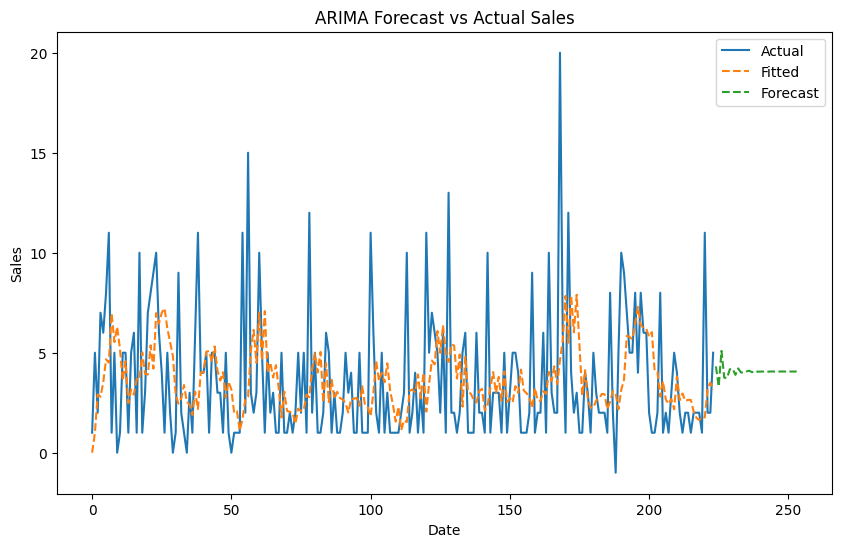

In [25]:
# Graficar los valores reales y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(df_arima.index, df_arima['cantidad_ventas_producto'], label='Actual')
plt.plot(predictions.index, predictions, label='Fitted', linestyle='--')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()